# DEMO: Running FastCAM for the Exceptionally Impatient

### Import Libs

In [1]:
import os
from IPython.display import Image

Lets load the **PyTorch** Stuff.

In [2]:
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

import warnings
warnings.filterwarnings('ignore')

Now we import the saliency libs for **this package**.

In [3]:
import maps
import misc
import mask
import norm
import resnet

### Set Adjustable Parameters
This is where we can set some parameters like the image name and the layer weights.

In [4]:
input_image_name    = "ILSVRC2012_val_00049934.224x224.png"     # Our input image to process 
output_dir          = 'outputs'                                 # Where to save our output images
input_dir           = 'images'                                  # Where to load our inputs from
in_height           = 224                                       # Size to scale input image to
in_width            = 224                                       # Size to scale input image to
cam_method          = 'gradcam'                                 # 'gradcam', 'gradcampp' or 'xgradcam'

Now we set up what layers we want to sample from and what weights to give each layer. We specify the layer block name within ResNet were we will pull the forward SMOE Scale results from. The results will be from the end of each layer block.   

In [5]:
weights             = [1.0, 1.0, 1.0, 1.0, 1.0]                    # Equal Weights work best 
                                                                   # when using with GradCAM 
layers              = ['relu','layer1','layer2','layer3','layer4']

**OPTIONAL:** We can auto compute which layers to run over by setting them to *None*. By default, this will select the last ReLU on each bottleneck layer. This is slightly more accurate than the above but is also a little slower since it will compute SMOE Scale activations over more maps. The *ROAR/KAR combined score for this is 1.45 whereas it is 1.44 for the above*. 

In [6]:
#weights             = None
#layers              = None

### Set Up Loading and Saving File Names
Lets touch up where to save output and what name to use for output files. 

In [7]:
save_prefix         = os.path.split(os.path.splitext(input_image_name)[0])[-1]  # Chop the file extension and path
load_image_name     = os.path.join(input_dir, input_image_name)

os.makedirs(output_dir, exist_ok=True)

Take a look at the input image ...
Good Doggy!

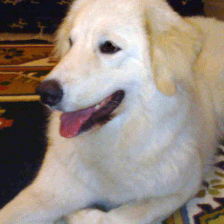

In [8]:
Image(filename=load_image_name) 

### Set Up Usual PyTorch Network Stuff
Go ahead and create a standard PyTorch device. It can use the CPU if no GPU is present. This demo works pretty well on just CPU. 

In [9]:
device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now we will create a model. Here we have a slightly customized ResNet that will only propagate backwards the last few layers. The customization is just a wrapper around the stock ResNet that comes with PyTorch. SMOE Scale computation does not need any gradients and GradCAM variants only need the last few layers. This will really speed things up, but don't try to train this network. You can train the regular ResNet if you need to do that. Since this network is just a wrapper, it will load any standard PyTorch ResNet training weights.  

In [10]:
model       = resnet.resnet50(pretrained=True)
model       = model.to(device)

### Load Images
Lets load in our image into standard torch tensors. We will do a simple resize on it.

In [11]:
in_tensor   = misc.LoadImageToTensor(load_image_name, device)
in_tensor   = F.interpolate(in_tensor, size=(in_height, in_width), mode='bilinear', align_corners=False)

For illustration purposes, Lets also load a non-normalized version of the input.

In [12]:
raw_tensor  = misc.LoadImageToTensor(load_image_name, device, norm=False)
raw_tensor  = F.interpolate(raw_tensor, size=(in_height, in_width), mode='bilinear', align_corners=False)

### Set Up Saliency Objects

Choose our layer normalization method. 

In [13]:
#norm_method     = norm.GaussNorm2D
norm_method     = norm.GammaNorm2D # A little more accurate, but much slower

We create an object to create the saliency map given the model and layers we have selected. 

In [14]:
getSalmap   = maps.SaliencyModel(model, layers, output_size=[in_height,in_width], weights=weights, 
                                 norm_method=norm_method, cam_method=cam_method)

Now we set up our masking object to create a nice mask image of the %10 most salient locations. You will see the results below when it is run.

In [15]:
getMask     = mask.SaliencyMaskDropout(keep_percent = 0.1, scale_map=False)

### Run Saliency
Now lets run our input tensor image through the net and get the 2D saliency map back. 

In [16]:
cam_map,_,_ = getSalmap(in_tensor)

### Visualize It
Take the images and create a nice tiled image to look at. This will created a tiled image of:

    (1) The input image.
    (2) The saliency map.
    (3) The saliency map overlaid on the input image.
    (4) The raw image enhanced with the most salient locations.
    (5) The top 10% most salient locations. 

In [17]:
images      = misc.TileOutput(raw_tensor, cam_map, getMask)

We now put all the images into a nice grid for display.

In [18]:
images      = make_grid(torch.cat(images,0), nrow=5)

... save and look at it. 

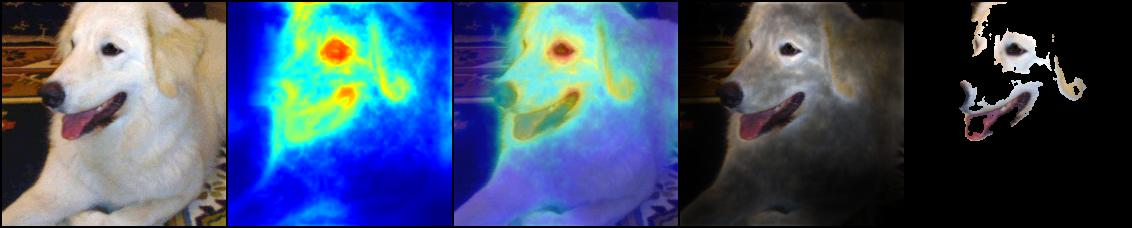

In [19]:
output_name = "{}.FASTCAM.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
Image(filename=output_path) 

This image should look **exactly** like the one on the README.md on Github minus the text. 